In [1]:
%%capture
!pip install pandas
!pip install tensorflow
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy

from google.colab import files
uploaded = files.upload()

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 4)
np.random.seed(seed = 23)

In [3]:
data = pd.read_csv('Data/train.csv')
data = data.drop(columns=['id'])
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])

In [5]:
data['tokenized'] = tokenizer.texts_to_sequences(data['tweet'])
data.head()

,label,tweet,tokenized
0,0,@user when a father is dysfunctional and is s...,"[1, 34, 4, 252, 11, 16533, 7, 11, 20, 2753, 97..."
1,0,@user @user thanks for #lyft credit i can't us...,"[1, 1, 170, 9, 5701, 2600, 5, 68, 452, 680, 69..."
2,0,bihday your majesty,"[62, 26, 3422]"
3,0,#model i love u take with u all the time in ...,"[140, 5, 13, 37, 76, 16, 37, 21, 2, 39, 8, 162..."
4,0,factsguide: society now #motivation,"[2946, 1621, 49, 299]"


In [6]:
vocab_size = len(tokenizer.word_index) + 1
length_size = 15
embedding_dim = 300

In [7]:
X = pad_sequences(sequences = data['tokenized'],
                  maxlen = length_size,
                  padding = 'post')

y = data['label']

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X,
                                                                y, 
                                                                test_size = 0.15,
                                                                random_state = 23)

## Model 1

In [9]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    input_length = length_size))
model.add(Conv1D(filters = 32,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate = 0.2))
model.add(Dense(units = 1,
                activation = 'sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 300)           13767000  
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 225       
Total params: 13,796,057
Trainable params: 13,796,057
Non-trainable params: 0
____________________________________________

In [11]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [12]:
%%time

history_model = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_validation, y_validation),
                    batch_size = 100,
                    epochs = 20,
                    callbacks = [es])

Epoch 1/20
272/272 [==============================] - 61s 166ms/step - loss: 0.3229 - accuracy: 0.9072 - val_loss: 0.1205 - val_accuracy: 0.9585
Epoch 2/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0654 - accuracy: 0.9774 - val_loss: 0.1112 - val_accuracy: 0.9627
Epoch 3/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0230 - accuracy: 0.9934 - val_loss: 0.1269 - val_accuracy: 0.9625
Epoch 4/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.1441 - val_accuracy: 0.9620
Epoch 5/20
272/272 [==============================] - 45s 165ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.1612 - val_accuracy: 0.9618
Epoch 6/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.1718 - val_accuracy: 0.9608
CPU times: user 8min 12s, sys: 12.6 s, total: 8min 24s
Wall time: 4min 46s


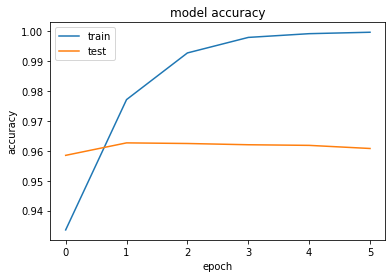

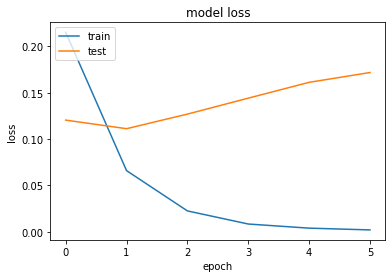

In [13]:
# summarize history for accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
predicted = (model.predict(X_validation) > 0.5).astype("int32")
print('Accuracy: {:.4f}'.format(f1_score(predicted, y_validation, average='weighted')))

Accuracy: 0.9624


## Model 2

In [15]:
model2 = Sequential()
model2.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    input_length = length_size))
model2.add(Conv1D(filters = 32,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))
model2.add(MaxPooling1D())
model2.add(Conv1D(filters = 64,
                 kernel_size = 5,
                 padding = 'same',
                 activation = 'relu'))
model2.add(MaxPooling1D())
model2.add(Flatten())
model2.add(Dropout(rate = 0.2))
model2.add(Dense(units = 1,
                activation = 'sigmoid'))

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 300)           13767000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 64)             10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 192)              

In [17]:
model2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [18]:
%%time

history_model2 = model2.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_validation, y_validation),
                    batch_size = 100,
                    epochs = 20,
                    callbacks = [es])

Epoch 1/20
272/272 [==============================] - 47s 170ms/step - loss: 0.2853 - accuracy: 0.9180 - val_loss: 0.1212 - val_accuracy: 0.9589
Epoch 2/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0613 - accuracy: 0.9771 - val_loss: 0.1126 - val_accuracy: 0.9616
Epoch 3/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0176 - accuracy: 0.9947 - val_loss: 0.1455 - val_accuracy: 0.9589
Epoch 4/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.1848 - val_accuracy: 0.9591
Epoch 5/20
272/272 [==============================] - 45s 165ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.2139 - val_accuracy: 0.9566
Epoch 6/20
272/272 [==============================] - 45s 166ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2306 - val_accuracy: 0.9575
CPU times: user 7min 59s, sys: 12.8 s, total: 8min 11s
Wall time: 4min 33s


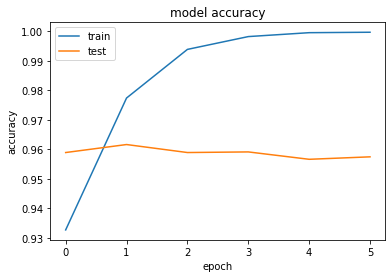

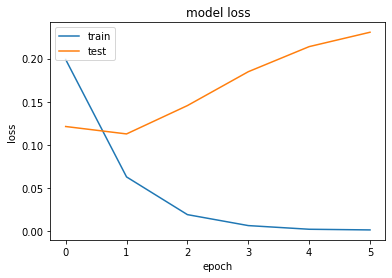

In [19]:
# summarize history for accuracy
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
predicted = (model2.predict(X_validation) > 0.5).astype("int32")
print('Accuracy: {:.4f}'.format(f1_score(predicted, y_validation, average='weighted')))

Accuracy: 0.9591


## Model 3

In [27]:
model3 = Sequential()
model3.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    input_length = length_size))
model3.add(Conv1D(filters = 32,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))
model3.add(MaxPooling1D())
model3.add(Flatten())
model3.add(Dropout(rate = 0.2))
model3.add(Dense(units = 64,
                activation = 'relu'))
model3.add(Dense(units = 1,
                activation = 'sigmoid'))

In [28]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 300)           13767000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 224)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                14400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [29]:
model3.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [30]:
%%time

history_model3 = model3.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_validation, y_validation),
                    batch_size = 100,
                    epochs = 20,
                    callbacks = [es])

Epoch 1/20
272/272 [==============================] - 46s 165ms/step - loss: 0.2644 - accuracy: 0.9279 - val_loss: 0.1175 - val_accuracy: 0.9589
Epoch 2/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0579 - accuracy: 0.9802 - val_loss: 0.1204 - val_accuracy: 0.9635
Epoch 3/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.1459 - val_accuracy: 0.9635
Epoch 4/20
272/272 [==============================] - 44s 163ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.1685 - val_accuracy: 0.9606
Epoch 5/20
272/272 [==============================] - 44s 162ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.1870 - val_accuracy: 0.9631
CPU times: user 6min 33s, sys: 10.6 s, total: 6min 44s
Wall time: 3min 43s


In [31]:
predicted = (model3.predict(X_validation) > 0.5).astype("int32")
print('Accuracy: {:.4f}'.format(f1_score(predicted, y_validation, average='weighted')))

Accuracy: 0.9653


## Model 4

In [32]:
model4 = Sequential()
model4.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    input_length = length_size))
model4.add(Conv1D(filters = 32,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))
model4.add(MaxPooling1D())
model4.add(Conv1D(filters = 64,
                 kernel_size = 5,
                 padding = 'same',
                 activation = 'relu'))
model4.add(MaxPooling1D())
model4.add(Flatten())
model4.add(Dropout(rate = 0.2))
model4.add(Dense(units = 64,
                activation = 'relu'))
model4.add(Dense(units = 1,
                activation = 'sigmoid'))

In [33]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 300)           13767000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 32)            28832     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 64)             10304     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 192)              

In [34]:
model4.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [37]:
%%time

history_model4 = model4.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_validation, y_validation),
                    batch_size = 100,
                    epochs = 20,
                    callbacks = [es])

Epoch 1/20
272/272 [==============================] - 46s 165ms/step - loss: 0.2721 - accuracy: 0.9140 - val_loss: 0.1178 - val_accuracy: 0.9612
Epoch 2/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0582 - accuracy: 0.9800 - val_loss: 0.1193 - val_accuracy: 0.9610
Epoch 3/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.1589 - val_accuracy: 0.9608
Epoch 4/20
272/272 [==============================] - 45s 164ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.1804 - val_accuracy: 0.9597
Epoch 5/20
272/272 [==============================] - 45s 165ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.2299 - val_accuracy: 0.9595
CPU times: user 6min 35s, sys: 10.7 s, total: 6min 46s
Wall time: 3min 44s


In [38]:
predicted = (model4.predict(X_validation) > 0.5).astype("int32")
print('Accuracy: {:.4f}'.format(f1_score(predicted, y_validation, average='weighted')))

Accuracy: 0.9606


In [39]:
test = pd.read_csv('Data/test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [40]:
test['tokenized'] = tokenizer.texts_to_sequences(test['tweet'])
test.head()

,id,tweet,tokenized
0,31963,#studiolife #aislife #requires #passion #dedic...,"[14173, 9102, 1540, 7666, 3, 176]"
1,31964,@user #white #supremacists want everyone to s...,"[1, 238, 40583, 74, 198, 3, 66, 2, 50, 14958, ..."
2,31965,safe ways to heal your #acne!! #altwaystohe...,"[651, 960, 3, 833, 26, 2484, 182, 80, 261]"
3,31966,is the hp and the cursed child book up for res...,"[11, 2, 7, 2, 28167, 588, 366, 46, 9, 412, 72,..."
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","[1671, 62, 3, 12, 161, 2963, 2595, 7553, 3875,..."


In [41]:
X_test = pad_sequences(sequences = test['tokenized'],
                       maxlen = length_size,
                       padding = 'post')

In [53]:
predicted = (model4.predict(X_test) > 0.5).astype("int32")
predicted

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [54]:
prediction = pd.DataFrame()
prediction['id'] = test['id']
prediction['label'] = predicted

prediction.head()

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0


In [55]:
prediction.to_csv('teste4.csv', index=False)